![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Compute total monthly precipitation and evapotranspiration for the relevant basins

In [1]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from common.config import read_config

In [2]:
conf=read_config()
datadir=conf["dataroot"]

In [3]:
basinsgpkg=os.path.join(datadir,'hydroshed_csl03_gl_l021.gpkg')
gdfbasins=gpd.read_file(basinsgpkg)

In [4]:
p_et=os.path.join(datadir,'p-et.nc')
ds=xr.open_dataset(p_et)
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB ...
Data variables:
    avg_ie      (valid_time, latitude, longitude) float32 1GB ...
    avg_tprate  (valid_time, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

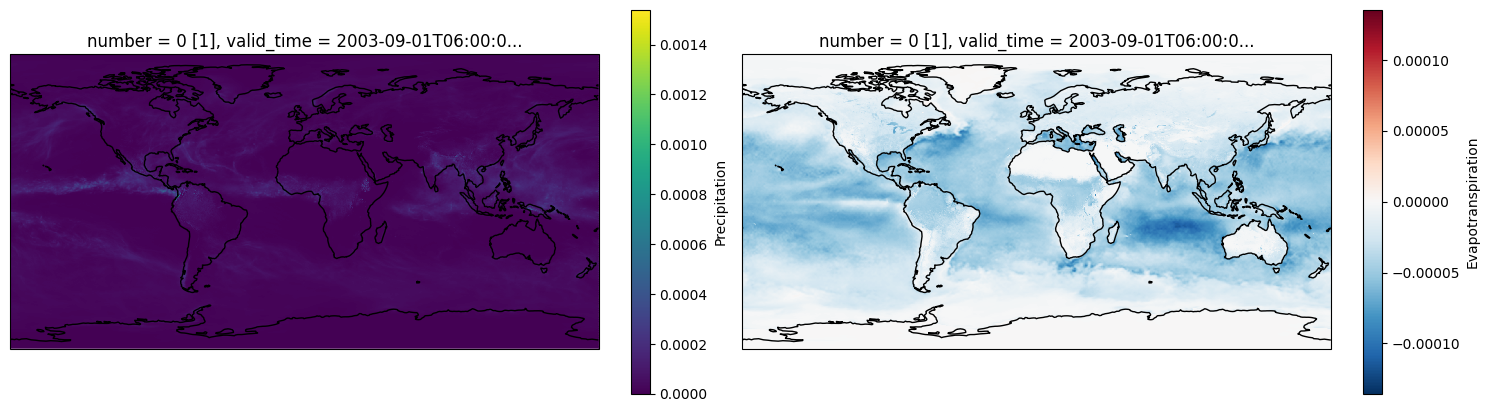

In [5]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15, 8),subplot_kw= dict(projection=ccrs.PlateCarree()))

#vmin=0, vmax =15
im1=ds.avg_tprate[20].plot(ax=axs[0],add_colorbar=False)
plt.colorbar(im1, fraction=0.03).set_label("Precipitation")
axs[0].coastlines()  

im2=ds.avg_ie[20].plot(ax=axs[1],add_colorbar=False)
plt.colorbar(im2, fraction=0.03).set_label("Evapotranspiration")
axs[1].coastlines()   
plt.tight_layout()

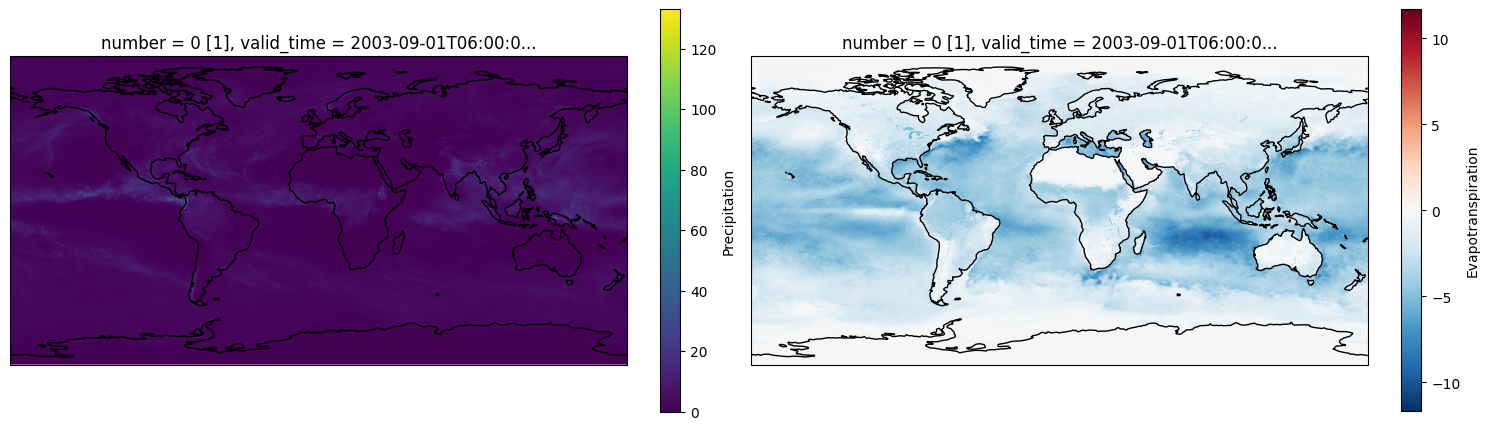

In [6]:
## Visualize precipitation and evapotranspiration in mm per day unit

fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(15,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_scld=ds*(24*3600) # Convert Convert kg m**-2 s**-1 to mm per day

im1=ds_scld.avg_tprate[20].plot(ax=axs[0],add_colorbar=False)
plt.colorbar(im1,fraction=0.03).set_label("Precipitation")
axs[0].coastlines()

im2=ds_scld.avg_ie[20].plot(ax=axs[1],add_colorbar=False)
plt.colorbar(im2,fraction=0.03).set_label("Evapotranspiration")
axs[1].coastlines()
plt.tight_layout()




In [7]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from shapely.geometry import Point

def era5_polygonmask(basinpolys,dsera5) ->xr.DataArray:
    


    dims=["longitude","latitude","basin"]
    coords={"longitude":dsera5.longitude,"latitude":dsera5.latitude,"basin":basinpolys.name}


    dtmp=xr.DataArray(np.zeros([dsera5.sizes['longitude'],dsera5.sizes['latitude'],len(basinpolys.geometry)]),coords=coords,dims=dims).stack(lonlat=("longitude","latitude"))


    #create a geoDataframe of points from the grid
    ggrd=gpd.GeoDataFrame(geometry=[Point(lon,lat) for lon,lat in dtmp.lonlat.values],crs=4326)
    
    if basinpolys.geometry.crs != ggrd.crs:
        #possibly convert the lon/lat grid in the desired projection before doing the polygon test
        ggrd=ggrd.to_crs(basinpolys.geometry.crs)
    

    #query using a spatial index and set values to 1
    for i,poly in enumerate(basinpolys.geometry): 
        idx=ggrd.sindex.query(poly,predicate="contains")
        dtmp[i,idx]=1.0
    
    
    dtmp=dtmp.unstack("lonlat")
    #logger.info("Applying SH analysis")
    #dsout=dtmp.sh.analysis(nmax,engine=engine) 

    return dtmp

In [8]:
dsmasks=era5_polygonmask(gdfbasins,ds)

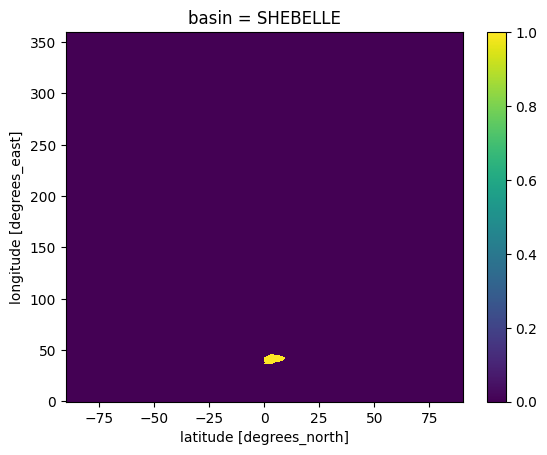

In [9]:
dsmasks.sel(basin="SHEBELLE").plot()

In [10]:
from shxarray.earth.constants import a_earth
dis=np.deg2rad(np.median(np.diff(ds.longitude)))*a_earth
area=dis**2
pxl_wght=np.cos(np.deg2rad(ds.latitude))*area
pxl_wght=xr.DataArray(pxl_wght,dims=["latitude"],coords=dict(latitude=ds.latitude))

In [11]:
ds_wghtd=pxl_wght*ds

In [12]:
N=ds.valid_time.dt.days_in_month #Number of days in month
total_ds_wgthd=ds_wghtd*(N*24*3600)

In [13]:
display(total_ds_wgthd)

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    avg_ie      (latitude, valid_time, longitude) float64 2GB -9.204e-08 ... ...
    avg_tprate  (latitude, valid_time, longitude) float64 2GB 5.262e-07 ... 3...

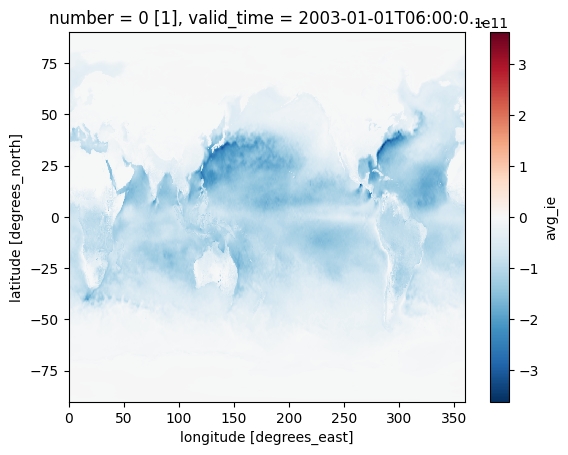

In [14]:
total_ds_wgthd.avg_ie.sel(valid_time='2003-01-01T06:00:00.000000000').plot()

In [15]:
dstest=dsmasks.sel(basin="SHEBELLE")*total_ds_wgthd

In [16]:
dstest

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
    basin       <U8 32B 'SHEBELLE'
Data variables:
    avg_ie      (longitude, latitude, valid_time) float64 2GB -0.0 0.0 ... -0.0
    avg_tprate  (longitude, latitude, valid_time) float64 2GB 0.0 0.0 ... 0.0

In [17]:
dstest=dstest.sum(dim=("latitude","longitude"))

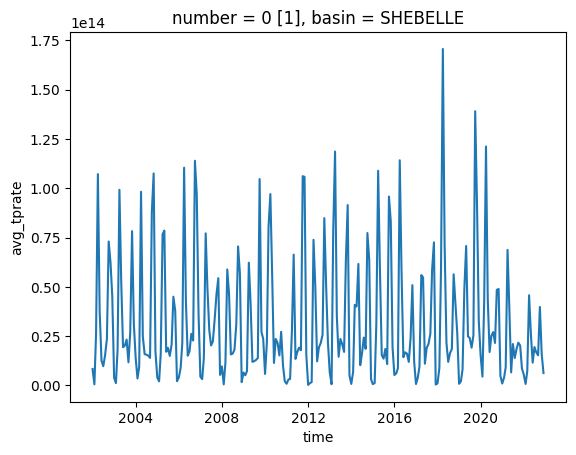

In [18]:
dstest.avg_tprate.plot()

In [20]:
from scipy import integrate

time_months=((total_ds_wgthd.valid_time-total_ds_wgthd.valid_time[0]).dt.days)/total_ds_wgthd.valid_time.dt.days_in_month

cumulative_precip = integrate.cumulative_trapezoid(total_ds_wgthd.avg_tprate, time_months,dx=1.0, axis=1,initial=None)
cumulative_et = cumulative_trapezoid(total_ds_wgthd.avg_ie, time_months,dx=1.0, axis=1,initial=None)
cumulative_precip.shape

(721, 251, 1440)

In [22]:
init_pnt=np.zeros((cumulative_precip.shape[0],1,cumulative_precip.shape[2]))
cumulative_precip=np.concatenate([init_pnt,cumulative_precip],axis=1) 
print(cumulative_precip.shape)

cumulative_et=np.concatenate([init_pnt,cumulative_et],axis=1) 
print(cumulative_et.shape)

(721, 252, 1440)
(721, 252, 1440)


In [23]:
total_ds_wgthd["cumulative_precip"]=(("latitude","valid_time","longitude"),cumulative_precip)
total_ds_wgthd["cumulative_et"]=(("latitude","valid_time","longitude"),cumulative_et)

In [24]:
total_ds_wgthd

<xarray.Dataset> Size: 8GB
Dimensions:            (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number             int64 8B 0
  * valid_time         (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 .....
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    expver             (valid_time) <U4 4kB '0001' '0001' ... '0001' '0001'
Data variables:
    avg_ie             (latitude, valid_time, longitude) float64 2GB -9.204e-...
    avg_tprate         (latitude, valid_time, longitude) float64 2GB 5.262e-0...
    cumulative_precip  (latitude, valid_time, longitude) float64 2GB 0.0 ... ...
    cumulative_et      (latitude, valid_time, longitude) float64 2GB 0.0 ... ...

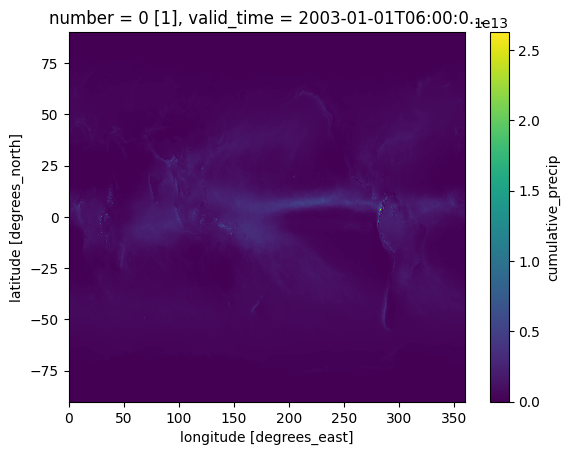

In [25]:
total_ds_wgthd.cumulative_precip.sel(valid_time="2003-01-01T06:00:00.000000000").plot()

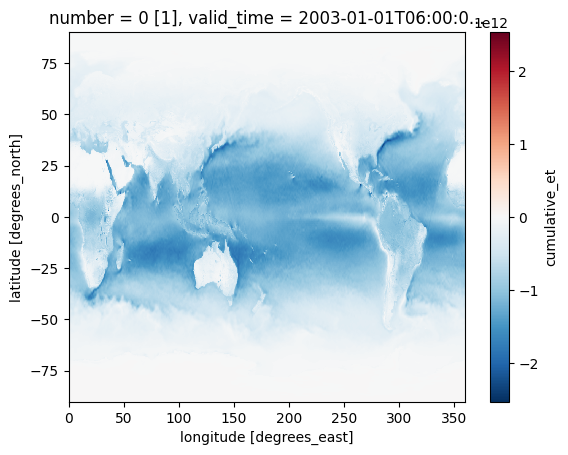

In [26]:
total_ds_wgthd.cumulative_et.sel(valid_time="2003-01-01T06:00:00.000000000").plot()

In [27]:
#save to netcdf for re-use
avg_tprateout=os.path.join(datadir,conf['ncp'])
total_ds_wgthd.avg_tprate.to_netcdf(avg_tprateout)

avg_etrateout=os.path.join(datadir,conf['ncet'])
total_ds_wgthd.avg_ie.to_netcdf(avg_etrateout)